In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib_venn import venn3

# Set the directory path
input_path = 'D:/PhD Work/Vijay/Data/Output_data/network_files/'
output_path = 'D:/PhD Work/Vijay/Data/Output_data/'
figure_path = 'D:/PhD Work/Vijay/Data/Figures/'

In [4]:
# Load the edges file
environments = ["Hospital", "MetaSUB", "Office"]
edges = {}

for env in environments:
    net_edges = pd.read_csv(input_path + env + '_edges.tsv', sep = ",")

    # Combine v1 and v2 into tuples and sort them
    sorted_tuples = [sorted((v1, v2)) for v1, v2 in zip(net_edges['v1'], net_edges['v2'])]

    # Create a new DataFrame with sorted tuples and Weight column
    sorted_df = pd.DataFrame({
        'v1': [t[0] for t in sorted_tuples],
        'v2': [t[1] for t in sorted_tuples],
        'Weight': net_edges['Weight']
    })

    edges[env] = net_edges

edges["Hospital"].head()

,v1,v2,Weight
0,Abiotrophia defectiva,Actinomyces viscosus,0.271919
1,Abiotrophia defectiva,Haemophilus parainfluenzae,0.279724
2,Abiotrophia defectiva,Neisseria sicca,0.222559
3,Abiotrophia defectiva,Proteus mirabilis,0.300740
4,Abiotrophia defectiva,Rothia mucilaginosa,0.287345


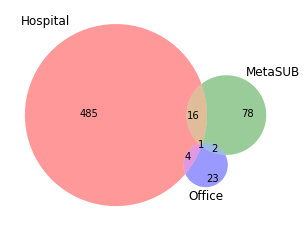

In [5]:
# Get the interactions from the dataframes
interactions_hospital = set(zip(edges["Hospital"]["v1"], edges["Hospital"]["v2"]))
interactions_meta = set(zip(edges["MetaSUB"]["v1"], edges["MetaSUB"]["v2"]))
interactions_office = set(zip(edges["Office"]["v1"], edges["Office"]["v2"]))

# Create the Venn diagram
venn3([interactions_hospital, interactions_meta, interactions_office], ('Hospital', 'MetaSUB', 'Office'))

# Display the Venn diagram
plt.show()

In [18]:
# Find the common edge (only one!)
interactions_all = interactions_hospital.intersection(interactions_meta, interactions_office)
interactions_all

{('Brevibacterium casei', 'Enhydrobacter aerosaccus')}

In [11]:
# Load the data files
file_path = "D:/PhD Work/Vijay/Data/Output_data/phyloseq_source/"
org_list = {}

# Listing the organisms from each environment (as present in the filtered data)
for env in environments:
    data = pd.read_csv(file_path + env + "_filtered_data.csv", sep = ",")
    org_list[env] = data["Species"].to_list()

# Getting the taxa binary data
org_df = pd.read_csv(output_path + "taxa_binary.csv", sep = ",", index_col = 0)
org_df

,Hospital,MetaSUB,Office
Abiotrophia defectiva,1,0,1
Achromobacter xylosoxidans,1,0,0
Acinetobacter baumannii,1,0,0
Acinetobacter johnsonii,1,1,0
Acinetobacter junii,1,0,1
...,...,...,...
Stutzerimonas stutzeri,1,1,1
Veillonella atypica,1,0,0
Veillonella parvula,1,1,0
Xanthomonas citri,1,0,0


In [16]:
# Ppresence/absence dataframe for the edges of the environments
edges_list = [interactions_hospital, interactions_meta, interactions_office]

# Create an empty dictionary to store the presence/absence data
edge_dict = {}

# Iterate over each set and create a dictionary entry with the set name as the key
for i, s in enumerate(edges_list):
    set_name = environments[i]
    # Create a dictionary where keys are element names and values are 1 if the element is present, else 0
    edge_dict[set_name] = {element: 1 if element in s else 0 for element in set.union(*edges_list)}

# Create a dataframe from the dictionary with set items as index
edges_df = pd.DataFrame(edge_dict).sort_index()
edges_df.to_csv(output_path + "edges_binary.csv", sep = "\t")

edges_df

Hospital  MetaSUB  \
Abiotrophia defectiva       Actinomyces viscosus               1        0   
                            Haemophilus parainfluenzae         1        0   
                            Neisseria sicca                    1        0   
                            Proteus mirabilis                  1        0   
                            Rothia mucilaginosa                1        0   
...                                                          ...      ...   
Streptococcus parasanguinis Stutzerimonas stutzeri             1        0   
                            Veillonella atypica                1        0   
                            Veillonella parvula                1        0   
Streptococcus salivarius    Veillonella atypica                1        0   
Streptococcus sanguinis     Veillonella parvula                1        0   

                                                        Office  
Abiotrophia defectiva       Actinomyces viscosus             0  
                            Haemophilus parainfluenzae       0  
                            Neisseria sicca                  0  
                            Proteus mirabilis                0  
                            Rothia mucilaginosa              0  
...                                                        ...  
Streptococcus parasanguinis Stutzerimonas stutzeri           0  
                            Veillonella atypica              0  
                            Veillonella parvula              0  
Streptococcus salivarius    Veillonella atypica              0  
Streptococcus sanguinis     Veillonella parvula              0  

[609 rows x 3 columns]

In [63]:
edge_details = pd.DataFrame(columns=["Environment", "Generalised", "Speciealised_both", 
                                     "Specialised_only_one", "Specialised_gen_edge"])

# Iterate over environments
for environment in environments:
    ge, se0, se1, se2 = 0, 0, 0, 0
    
    # Iterate over rows in the current environment
    for index, row in edges.get(environment, pd.DataFrame()).iterrows():
        if (row["v1"], row["v2"]) in edges_df.index:
            match = edges_df.loc[(row["v1"], row["v2"])]
            if match.sum() > 1:
                ge += 1
            else:
                test_list = [row["v1"], row["v2"]]
                selected_df = org_df.loc[org_df.index.isin(test_list)]
                sums = tuple(selected_df.sum(axis=1).to_list())
                if sums == (1, 1):
                    se0 += 1
                elif any((a == 1 and b > 1) or (a > 1 and b == 1) for a, b in [sums]):
                    se1 += 1
                elif any((a > 1 and b > 1) for a, b in [sums]):
                    se2 += 1
    
    # Append results to the output DataFrame
    edge_details = edge_details.append({"Environment": environment, "Generalised": ge, 
                                  "Speciealised_both": se0, "Specialised_only_one": se1, 
                                  "Specialised_gen_edge": se2}, ignore_index=True)

edge_details.set_index("Environment", inplace=True)
edge_details

<ipython-input-63-e69fd1783dcf>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  edge_details = edge_details.append({"Environment": environment, "Generalised": ge,
<ipython-input-63-e69fd1783dcf>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  edge_details = edge_details.append({"Environment": environment, "Generalised": ge,
<ipython-input-63-e69fd1783dcf>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  edge_details = edge_details.append({"Environment": environment, "Generalised": ge,


,Generalised,Speciealised_both,Specialised_only_one,Specialised_gen_edge
Environment,,,,
Hospital,21,95,228,162
MetaSUB,19,10,37,31
Office,7,2,18,3


In [64]:
# Define a function to convert values to percentages and normalize row-wise
def normalize_row_wise(row):
    total = row.sum()
    return row.apply(lambda x: (x / total) * 100 if total != 0 else 0)

edge_details_per = edge_details.apply(normalize_row_wise, axis=1)
edge_details_per

,Generalised,Speciealised_both,Specialised_only_one,Specialised_gen_edge
Environment,,,,
Hospital,4.150198,18.774704,45.059289,32.015810
MetaSUB,19.587629,10.309278,38.144330,31.958763
Office,23.333333,6.666667,60.000000,10.000000


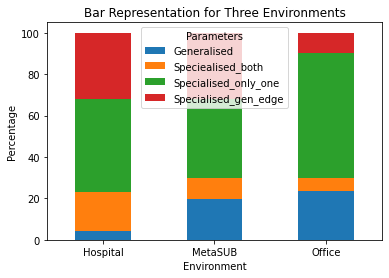

In [65]:
edge_details_per.plot(kind='bar', stacked=True)
plt.title('Bar Representation for Three Environments')
plt.xlabel('Environment')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Parameters')
plt.show()